In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist

import pydrake
from pydrake.all import (
    Quaternion,
    RotationMatrix,
    RollPitchYaw
)

from bingham_distribution import BinghamDistribution

Bingam Distribution for quaternions $q$:

- $M$ = 4x4 orthogonal orientation
- $Z$ = 4x4 diagonal concentration

$$p(q) = \dfrac{1}{C(Z)} e^{ \text{tr } Z M^T q q^T M}$$

In [137]:
def make_m_z_from_rpys(rpy, rpy_concentration):
    mode = RollPitchYaw(rpy).ToQuaternion()
    #rpy_concentration = np.abs(RotationMatrix(mode).multiply(rpy_concentration))
    rot_around_x = RollPitchYaw([np.pi, 0., 0.]).ToQuaternion()
    rot_around_y = RollPitchYaw([0., np.pi, 0.]).ToQuaternion()
    rot_around_z = RollPitchYaw([0., 0., np.pi]).ToQuaternion()
    m = np.stack([
        rot_around_x.multiply(mode).wxyz(),
        rot_around_y.multiply(mode).wxyz(),
        rot_around_z.multiply(mode).wxyz(),
        mode.wxyz()
    ], axis=1)
    z = np.array(
        [-rpy_concentration[0],
         -rpy_concentration[1],
         -rpy_concentration[2],
         0.
        ]
    )
    print("M: ", m)
    print("Z: ", z)
    # Reorder into canonical orders
    reorder_inds = np.argsort(z)
    z = z[reorder_inds]
    m = m[:, reorder_inds]
    
    print("M: ", m)
    print("Z: ", z)
    return z, m

dists = {
    "spread_1": BinghamDistribution(
        param_m=np.eye(4),
        param_z=np.array([-10, -10, -10, 0.])
    ),
    "tight_2": BinghamDistribution(
        param_m=np.eye(4),
        param_z=np.array([-1000, -10, -10, 0.])
    ),
    "tight": BinghamDistribution(
        param_m=np.eye(4),
        param_z=np.array([-1000, -1000, -1000, 0.])
    ),
}
dists = dict()
z, m = make_m_z_from_rpys([0., 0., np.pi/2.], [100, 100, 1])
dists["custom_1"] = BinghamDistribution(
    param_m=m, param_z=z
) 

datas = {}
for name, dist in dists.items():
    datas[name] = dist.random_samples(500)
    print(RollPitchYaw(Quaternion(datas[name][-1])).vector())

M:  [[ 4.32978028e-17  4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [-7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 4.32978028e-17  4.32978028e-17  7.07106781e-01  7.07106781e-01]]
Z:  [-100. -100.   -1.    0.]
M:  [[ 4.32978028e-17  4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [-7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 4.32978028e-17  4.32978028e-17  7.07106781e-01  7.07106781e-01]]
Z:  [-100. -100.   -1.    0.]
[0.00581473 0.10023477 2.64157877]


<IPython.core.display.Javascript object>


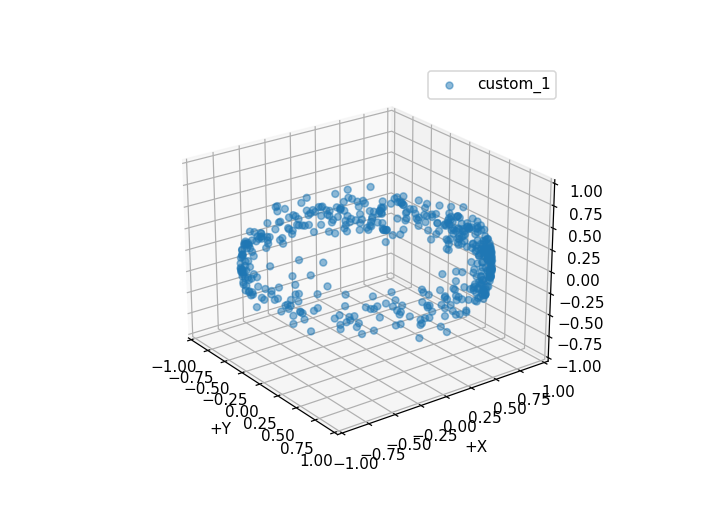

In [138]:
%matplotlib notebook

def draw_data(name, data, ax):
    # Rotate +x by data to get a view into these points on the 3D sphere
    tfd_vecs = []
    vec = np.array([1., 0., 0.])
    for q in data:
        tfd_vecs.append(RotationMatrix(quaternion=Quaternion(q)).multiply(vec))
    tfd_vecs = np.stack(tfd_vecs)

    ax.scatter(tfd_vecs[:, 0], tfd_vecs[:, 1], tfd_vecs[:, 2], label=name, alpha=0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for name, data in datas.items():
    draw_data(name, data, ax)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.xlabel("+Y")
plt.ylabel("+X")
plt.legend()
plt.show()